# NetColoc analysis of rare variants in Autism spectrum disorder (ASD) and Congenital Heart Disease (CHD)

Example of NetColoc workflow on genes associated with rare exome variants in ASD and CHD

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets


# _Obtain input gene sets and interactome_

### 1. Load required packages

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

# need ddot to parse the ontology
import ddot
from ddot import Ontology

# annotate the clusters
# gprofiler prelim annotation
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from statsmodels.stats import contingency_tables

import requests

# find human orthologs of mouse genes
import mygene
mg = mygene.MyGeneInfo()

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

# % matplotlib inline

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [5]:

import sys
sys.path.append('/Users/brinrosenthal/Documents/GitHub/NetColoc/netcoloc/')

import netprop_zscore
import netprop
import network_colocalization

import imp
imp.reload(netprop_zscore)
imp.reload(netprop)
imp.reload(network_colocalization)

<module 'network_colocalization' from '/Users/brinrosenthal/Documents/GitHub/NetColoc/netcoloc/network_colocalization.py'>

In [6]:
# from netcoloc import netprop_zscore, netprop, network_colocalization

### 2. Load two gene sets of interest


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [7]:
# load rare variants Satterstrom et al 2020; PMID: 31981491

ASD_rare_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
ASD_rare_df.index = ASD_rare_df['gene']
print('number ASD genes:')
print(len(ASD_rare_df))
ASD_rare_genes = ASD_rare_df.index.tolist() # define rare variant genes to seed network propagation
print(ASD_rare_genes[0:5])

number ASD genes:
102
['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


In [8]:
# load CHD rare variant genes from Jin et al 2017; PMID: 28991257
CHD_rare_df = pd.read_csv('data/CHD_HC.tsv',sep='\t')

CHD_rare_genes = CHD_rare_df['0'].tolist()
print('number CHD genes:')
print(len(CHD_rare_genes))
print(CHD_rare_genes[0:5])

number CHD genes:
66
['KMT2D', 'CHD7', 'PTPN11', 'NSD1', 'NOTCH1']


In [9]:
# how much overlap between gene sets?
print('number of ASD and CHD genes overlapping:')
print(len(np.intersect1d(ASD_rare_genes,CHD_rare_genes)))

number of ASD and CHD genes overlapping:
6


### 3. Select molecular interaction network to use for the analysis. 

Identify network UUID on  Ndex (Pratt et al. 2015) and use this to import to jupyter notebook using. 

**Coverage**. Larger, denser interactomes will be more inclusive and be amenable to creating more granular models. Human curated interactomes are smaller, sparser and are biased towards known biology. Many, however, have richer descriptions of the relationships. Data derived interactomes based on specific projects have the advantage that the experimental context is well-defined and consistent.  


**Interaction Types**. The edges that were useful in computing the coloc may not be useful for interpretation. For example, the edges in PCNet are not typed. For purposes of interpretation we need to know how the genes relate to each other. Further, we are best able to understand physical interactions, and so it may be most useful to review the nodes in a community or other subnetwork using a protein-protein interactome, or at least one in which the edges can be filtered when needed.

**Net recommendation**: use an inclusive interactome for generating the model but then annotate subsystem networks with relationships derived from richer, if less comprehensive, sources. Or from sources specifically relevant to the experimental context.


**Usage note**: PCnet is a general purpose interactome, a good starting place https://www.sciencedirect.com/science/article/pii/S2405471218300954

In [10]:

interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

number of nodes:
18820

number of edges:
2693109


In [11]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

### 4. Precalculate matrices needed for propagation. This step should take a few minutes 

Network propagation from genes on selected interactome
- Control for degree of input genes
- Generate a proximity z-score, which defines genes which are closer to input set than expected by chance.
- Repeat for rare and common variant genes, defined above

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [12]:
# pre calculate mats used for netprop... this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


### 5. Subset seed genes to those found in the selected interactome.

In [13]:
# subset seed genes to those found in interactome
print(len(ASD_rare_genes))
ASD_rare_genes = list(np.intersect1d(ASD_rare_genes,int_nodes))
print(len(ASD_rare_genes))

print(len(CHD_rare_genes))
CHD_rare_genes = list(np.intersect1d(CHD_rare_genes,int_nodes))
print(len(CHD_rare_genes))


102
96
66
60


### 6. Run network propagation from both seed gene sets independently.

In [14]:
# ASD variant netprop
print('\nCalculating ASD variant z-scores: ')
z_ASD, Fnew_ASD, Fnew_rand_ASD = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    ASD_rare_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_ASD = pd.DataFrame({'z':z_ASD})

z_ASD.sort_values('z',ascending=False).head()


Calculating ASD variant z-scores: 


,z
TRIP12,23.674264
NUP155,20.643715
ADNP,20.489814
TLK2,19.532815
CREBBP,18.945873


In [15]:
# CHD variant netprop
print('\nCalculating CHD variant z-scores: ')
z_CHD, Fnew_CHD, Fnew_rand_CHD = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    CHD_rare_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_CHD = pd.DataFrame({'z':z_CHD})
z_CHD.sort_values('z',ascending=False).head()


Calculating CHD variant z-scores: 


,z
ACTB,25.046474
RPL5,24.320330
SMAD2,22.308273
U2SURP,22.132597
NAA15,20.724822


### 7. Compute the network colocalization enrichment for gene set pair. If gene sets are significantly colocalized, proceed with analysis. 


Size of network co-localization subgraph compared to null model created by permuting individual propagation z-scores. 


In [16]:


# ------ customize this section based on your gene sets and how they should be labeled -------
d1='ASD'
d2='CHD'

seed_dict = {'ASD':ASD_rare_genes,'CHD':CHD_rare_genes}
# --------------------------------------------------------------------------------------------

zthresh=3

z_d1d2_size, high_z_rand = network_colocalization.calculate_expected_overlap(
    z_ASD['z'],
    z_CHD['z'],
    plot=False,
    num_reps=100,
    z_score_threshold=zthresh,
    z1_threshold=1.5,
    z2_threshold=1.5
)

ztemp = (z_d1d2_size - np.mean(high_z_rand)) / np.std(high_z_rand)
ptemp = norm.sf(ztemp)
print(d1 + ' + ' + d2)
print('size of network intersection = ' + str(z_d1d2_size))
obs_exp_temp = float(z_d1d2_size) / np.mean(high_z_rand)
print('observed size/ expected size = ' + str(obs_exp_temp))
print('p = ' + str(ptemp))

# save the num overlap and overlap p-val
network_num_overlap = z_d1d2_size
network_pval_overlap = ptemp
network_obs_exp = obs_exp_temp
network_exp_mean_overlap = np.mean(high_z_rand)
network_exp_std_overlap = np.std(high_z_rand)


ASD + CHD
size of network intersection = 773
observed size/ expected size = 3.013292792266012
p = 0.0


### 8. Plot the sizes of the observed and expected NetColoc subgraphs.

(-1, 2)

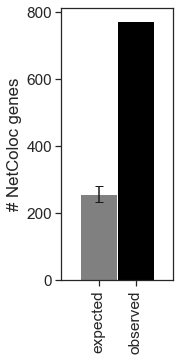

In [17]:
# plot the observed and expected overlaps
plt.figure(figsize=(2,5))
plt.bar([0,1],[network_exp_mean_overlap,network_num_overlap],color=['gray','black'],width=1)
plt.errorbar([0],[network_exp_mean_overlap],[2*network_exp_std_overlap],color='k',capsize=4)
plt.ylabel('# NetColoc genes')
plt.xticks([0,1],['expected','observed'],rotation='vertical')
plt.xlim([-1,2])




### 9. Compute network colocalization subgraph.

In [18]:
# select genes in network intersection, make a subgraph

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_int,z_ASD['z'],z_CHD['z'],z_score_threshold=zthresh,
                                                                     z1_threshold=1.5,z2_threshold=1.5)
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))

773
26351


### 10. Transform NetColoc subgraph edges to cosine similarities

Cosine similarity transformation (and network transformations in general) provide better visualization of clusters


In [ ]:
G_cosSim=network_colocalization.transform_edges(G_overlap,method='cosine_sim',edge_weight_threshold=0.95)

computing the adjacency matrix...
computing the cosine similarity...


# _Compute network colocalized systems map_

### 11. Convert network colocalization subgraph to form used in community detection module

In [19]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df['d1_seeds']=0
node_df['d2_seeds']=0
node_df['d1_seeds'].loc[list(np.intersect1d(seed_dict[d1],node_df.index.tolist()))]=1
node_df['d2_seeds'].loc[list(np.intersect1d(seed_dict[d2],node_df.index.tolist()))]=1
node_df['z_d1']=z_ASD.loc[list(G_overlap.nodes)]['z']
node_df['z_d2']=z_CHD.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_d1']*node_df['z_d2']
node_df['d1_name']=d1
node_df['d2_name']=d2
node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head(15)

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds
PTEN,1,1,17.775818,18.270646,324.775666,ASD,CHD,2
CTNNB1,1,1,15.369891,16.212593,249.185790,ASD,CHD,2
POGZ,1,1,12.518539,13.035299,163.182897,ASD,CHD,2
KMT2C,1,1,12.964197,12.579514,163.083297,ASD,CHD,2
NSD1,1,1,12.263667,12.748115,156.338630,ASD,CHD,2
KDM5B,1,1,12.795978,11.553692,147.840781,ASD,CHD,2
CHD4,0,1,4.485093,17.863170,80.117979,ASD,CHD,1
KMT2A,0,1,4.267999,16.113881,68.774032,ASD,CHD,1
CDK13,0,1,4.335774,15.374536,66.660517,ASD,CHD,1
KDM5A,0,1,4.980719,13.264934,66.068913,ASD,CHD,1


### 12. Run community detection on NetColoc subgraph (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [20]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name('ASD_CHD_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

773
26351


In [21]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_CHD_NetColoc_subgraph
# nodes: 81
# edges: 85


In [22]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

### 13. Convert NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in python.


In [23]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_hier.nodes()))
print('\nnumber of edges:')
print(len(G_hier.edges()))

number of nodes:
81

number of edges:
85


In [24]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
# relabel nodes in G_ASD
# G_ASD=nx.relabel_nodes(G_ASD,dict(hier_df['CD_CommunityName']))
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,MYO16 ATF7IP RBPMS2 ESRP1 ATP1A3 PIAS3 SCN1A S...,770,False,9.589,,,0,0.0,0.0,130,C773,C773,0
1,PIAS3 HIST1H3H MECP2 PRDM2 KDM4B AC008575.1 FO...,273,False,8.093,,,0,0.0,0.0,6,C774,C774,1
2,ATF7IP NLRP6 CDK13 ESRP1 BAZ1A ZNF148 RBPJ ITS...,241,False,7.913,,,0,0.0,0.0,13,C775,C775,2
3,MYO16 ATP1A3 SCN1A SPTBN2 CACNA2D1 ANKS1B NEFL...,165,False,7.366,,,0,0.0,0.0,86,C777,C777,3
4,PIAS3 AC008575.1 FOXD3 TRABD2A ZEB2 POU2F1 HIP...,109,False,6.768,,,0,0.0,0.0,12,C779,C779,4


### 14. Remove systems with no seed genes (optional)

In [25]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds = [],[]
frac_d1_seeds, frac_d2_seeds=[],[]
systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    num_ASD_temp = len(list(np.intersect1d(system_genes,seed_dict['ASD'])))
    num_CHD_temp = len(list(np.intersect1d(system_genes,seed_dict['CHD'])))
    if (num_ASD_temp+num_CHD_temp)>0: # keep the system if it has at least 1 seed genes
        systems_keep.append(c)
        num_d1_seeds.append(num_ASD_temp)
        num_d2_seeds.append(num_CHD_temp)
        
        frac_d1_seeds.append(num_ASD_temp/np.float(len(system_genes)))
        frac_d2_seeds.append(num_CHD_temp/np.float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.add(frac_d1_seeds,frac_d2_seeds))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print(len(hier_df))

hier_df.head()
    

42


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,,,
C773,MYO16 ATF7IP RBPMS2 ESRP1 ATP1A3 PIAS3 SCN1A S...,770,False,9.589,,,0,0.0,0.0,130,C773,C773,0,47,29,0.061039,0.037662,0.901299
C774,PIAS3 HIST1H3H MECP2 PRDM2 KDM4B AC008575.1 FO...,273,False,8.093,,,0,0.0,0.0,6,C774,C774,1,20,11,0.073260,0.040293,0.886447
C775,ATF7IP NLRP6 CDK13 ESRP1 BAZ1A ZNF148 RBPJ ITS...,241,False,7.913,,,0,0.0,0.0,13,C775,C775,2,11,9,0.045643,0.037344,0.917012
C777,MYO16 ATP1A3 SCN1A SPTBN2 CACNA2D1 ANKS1B NEFL...,165,False,7.366,,,0,0.0,0.0,86,C777,C777,3,12,6,0.072727,0.036364,0.890909
C779,PIAS3 AC008575.1 FOXD3 TRABD2A ZEB2 POU2F1 HIP...,109,False,6.768,,,0,0.0,0.0,12,C779,C779,4,7,6,0.064220,0.055046,0.880734


In [26]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print(len(G_hier.nodes()))
print(len(G_hier.edges()))

42
43


### 15. Annotate systems with gprofiler. 

Annotate systems if they are significantly enriched for a gene ontology biological process term, which has a term size of at least 50 genes, and fewer than 1000 genes. Also require that the GO term is enriched with p<1E-5, and shares at least 3 genes with the focal system to annotate, to increase the stringency of the annotation. Choose the GO term which meets these criteria, and which has the highest sum of precision and recall to annotate. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [ ]:
# gprofiler annotation of clusters

# hier_df = hier_df.sort_values('name')

# ....this needs to be better...

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            # try sorting by precision + recall
            #gp_temp['prec_plus_recall']=gp_temp['precision']+gp_temp['recall']
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

# _Validate identified genes and systems_

### 16. Load and parse mouse knockout database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology

TODO: wrap some of this into a separate module... maybe

In [27]:
# download MGI phenotype data
url = 'http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt'
r = requests.get(url,allow_redirects=True)
open('MGI_PhenoGenoMP.rpt','wb').write(r.content)

# parse the downloaded MGI phenotype data
mgi_df = pd.read_csv('MGI_PhenoGenoMP.rpt',sep='\t',
                    names=['MGI_Allele_Accession_ID','Allele symbol','involves','MP','PMID','MGI_marker_accession_ID'])
# extract gene names
gene_name = [a.split('<')[0] for a in mgi_df['Allele symbol'].tolist()]
mgi_df['gene_name']=gene_name
mgi_df.index=mgi_df['gene_name']
display(mgi_df.head())

# map mouse genes to human orthologs
mouse_genes = list(np.unique(mgi_df['gene_name']))
# mouse_genes = [g for g in mouse_genes if (not g.startswith('+'))]
mg_mapped = mg.querymany(mouse_genes,as_dataframe=True,species=['mouse','human'],scopes='symbol',fields='symbol')

# drop genes with no human ortholog
print(len(mg_mapped))
mg_mapped = mg_mapped.dropna(subset=['symbol'])
print(len(mg_mapped))
# drop duplicates
mg_mapped = mg_mapped[~mg_mapped.index.duplicated(keep='first')]
print(len(mg_mapped))
mg_mapped.head()

mgi_df['human_ortholog']=mgi_df['gene_name'].map(dict(mg_mapped['symbol']))
mgi_df.head()

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name
gene_name,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24101...done.
Finished.
35 input query terms found dup hits:
	[('Adam1a', 2), ('Adam1b', 2), ('Ccdc39', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 2), ('Fer1l4',
12229 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [28]:
# download the mammalian phenotype ontology, parse with ddot
url = 'http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology'
r = requests.get(url,allow_redirects=True)
open('MPheno_OBO.ontology','wb').write(r.content)
ddot.parse_obo('MPheno_OBO.ontology',
               'parsed_mp.txt',
              'id2name_mp.txt',
              'id2namespace_mp.txt',
              'altID_mp.txt')


MP2desc = pd.read_csv('id2name_mp.txt',sep='\t',
                      names=['MP','description'],index_col='MP')

MP2desc=MP2desc.loc[MP2desc.index.dropna()] # drop NAN from index
print(len(MP2desc))


display(MP2desc.head())

hierarchy = pd.read_table('parsed_mp.txt',
                          sep='\t',
                          header=None,
                          names=['Parent', 'Child', 'Relation', 'Namespace'])

display(hierarchy.head())

MPO = Ontology.from_table(
    table=hierarchy,
    parent='Parent',
    child='Child',
    add_root_name='MP:00SUPER',
    ignore_orphan_terms=True)
#MPO.clear_node_attr()
#MPO.clear_edge_attr()

# add description to node attribute
terms_keep = list(np.unique(hierarchy['Parent'].tolist()+hierarchy['Child'].tolist()))
MPO.node_attr=MP2desc.loc[terms_keep]

MPO

14470


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13337 terms, 0 gene-term relations, 16846 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

### 17. Identify phenotype(s) of interest. Recommend including a negative control.

#### here we find MPO terms related to brain

Modify as needed for each specific project

In [29]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print(len(MP_focal_brain_list))
print(MP_focal_brain_list[0:10])

179
['MP:0000778', 'MP:0000811', 'MP:0000937', 'MP:0000938', 'MP:0000939', 'MP:0000940', 'MP:0000958', 'MP:0000965', 'MP:0000966', 'MP:0000968']


In [30]:
# test for enrichment in root node
OR_p_list,OR_CI_list,log_OR_list = [],[],[]
num_genes_in_term_list=[]

MP_keep_list = []

# root node is the largest node
hier_df.index=hier_df['name']
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]

# get list of node names from G_int
G_int_nodes = list(G_int.nodes())

# add a negative control phenotype: abnormal mature B cell morphology: MP:0008171
# negative controls are tough here because we're dealing with development... which impacts almost everything
for MP_focal in ['MP:0008171']+MP_focal_brain_list:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal,verbose=False)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=[MP_focal]


    # check enrichment in root node
    focal_genes = hier_df['CD_MemberList'].loc[root_node].split(' ')
    mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
    mgi_temp = mgi_temp.dropna(subset=['human_ortholog'])
    mgi_genes = list(np.unique(mgi_temp['human_ortholog']))
    mgi_genes = list(np.intersect1d(mgi_genes,G_int_nodes)) 
    
    if (len(mgi_genes)>10) and (len(mgi_genes)<2000): # only test if there are at least 10 genes, and fewer than 2000 genes
        print('\n'+MP_desc_focal)
        print('number of genes in root node = '+str(len(focal_genes)))
        print('number of genes in focal MPO term = '+str(len(mgi_genes)))

        q00 = len(np.intersect1d(mgi_genes,focal_genes))
        print('number overlapping genes = '+str(q00))
        q01 = len(mgi_genes)-q00
        q10 = len(focal_genes)-q00
        q11 = len(G_int_nodes)-q00-q01-q10
        table_temp = [[q00,q01],[q10,q11]]

        CT= contingency_tables.Table2x2(table_temp)
        OR_p_temp = CT.log_oddsratio_pvalue()
        OR_CI_temp = CT.log_oddsratio_confint()
        log_OR_temp = CT.log_oddsratio
        print(OR_p_temp)
        print(OR_CI_temp)
        print(log_OR_temp)

        OR_p_list.append(OR_p_temp)
        OR_CI_list.append(OR_CI_temp)
        log_OR_list.append(log_OR_temp)
        num_genes_in_term_list.append(len(mgi_genes))
        
        MP_keep_list.append(MP_focal)

    
OR_CI_lower, OR_CI_upper = zip(*OR_CI_list)

root_KO_brain_df = pd.DataFrame({'OR_p':OR_p_list,'log_OR':log_OR_list,
                           'log_OR_CI_lower':OR_CI_lower,'log_OR_CI_upper':OR_CI_upper,
                          'num_genes_in_term':num_genes_in_term_list},
                          index=MP_keep_list)


abnormal mature B cell morphology
number of genes in root node = 770
number of genes in focal MPO term = 243
number overlapping genes = 16
0.050758302157714756
(-0.0016845814813924997, 1.0226673290299373)
0.5104913737742724

abnormal nervous system tract morphology
number of genes in root node = 770
number of genes in focal MPO term = 203
number overlapping genes = 28
7.064363918782034e-11
(0.9435945429746802, 1.754860778318353)
1.3492276606465166

hippocampal neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 27
number overlapping genes = 1
0.9189768413841193
(-2.1023314783704885, 1.894875427540397)
-0.10372802541504589

abnormal motor neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 165
number overlapping genes = 12
0.0413644308330553
(0.024133460102143345, 1.2082139854390603)
0.6161737227706019

motor neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 42
number ov


abnormal GABAergic neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 29
number overlapping genes = 1
0.8612857732176975
(-2.1739084714041863, 1.8180145376324535)
-0.17794696688586642

loss of GABAergic neurons
number of genes in root node = 770
number of genes in focal MPO term = 12
number overlapping genes = 1
0.4686886847279035
(-1.2910822233877135, 2.80569245819504)
0.7573051174036634

premature neuronal precursor differentiation
number of genes in root node = 770
number of genes in focal MPO term = 22
number overlapping genes = 3
0.035084862207620124
(0.091743408296727, 2.5313251635248353)
1.311534285910781

abnormal synaptic transmission
number of genes in root node = 770
number of genes in focal MPO term = 1072
number overlapping genes = 89
2.9537685851277294e-12
(0.5892880072941418, 1.0494459864142949)
0.8193669968542183

abnormal nervous system development
number of genes in root node = 770
number of genes in focal MPO term = 1212
number 


abnormal neuron differentiation
number of genes in root node = 770
number of genes in focal MPO term = 320
number overlapping genes = 36
5.721935395812551e-10
(0.7665591008704324, 1.4755958371496356)
1.121077469010034

abnormal hippocampus neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 117
number overlapping genes = 16
1.025588650547438e-06
(0.7949801178967065, 1.8597509210007077)
1.327365519448707

abnormal neuron proliferation
number of genes in root node = 770
number of genes in focal MPO term = 124
number overlapping genes = 18
5.60394593816925e-08
(0.8942549828409476, 1.904159849227656)
1.3992074160343018

abnormal sensory neuron physiology
number of genes in root node = 770
number of genes in focal MPO term = 64
number overlapping genes = 9
0.0001816066714732444
(0.6446336515369172, 2.061580857973469)
1.353107254755193

abnormal synaptic dopamine release
number of genes in root node = 770
number of genes in focal MPO term = 14
number ove

In [31]:
root_KO_brain_df['MP_description']=root_KO_brain_df.index.map(dict(MP2desc['description']))

root_KO_brain_df=root_KO_brain_df.sort_values('OR_p')
# root_KO_brain_df=root_KO_brain_df.sort_values('log_OR',ascending=False)
root_KO_brain_df.head(10)

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002882,1.389460e-25,1.015059,0.824770,1.205348,1509,abnormal neuron morphology
MP:0003861,4.831523e-24,1.053248,0.849125,1.257372,1212,abnormal nervous system development
MP:0008946,8.579277e-18,1.227887,0.947773,1.508000,496,abnormal neuron number
MP:0004811,3.930978e-17,1.129369,0.866323,1.392416,616,abnormal neuron physiology
MP:0002272,1.345358e-15,1.329136,1.003111,1.655161,329,abnormal nervous system electrophysiology
MP:0002206,6.124134e-13,0.898593,0.653902,1.143283,870,abnormal CNS synaptic transmission
MP:0003635,2.953769e-12,0.819367,0.589288,1.049446,1072,abnormal synaptic transmission
MP:0021009,3.802029e-12,0.815072,0.585027,1.045116,1076,abnormal synaptic physiology
MP:0008948,5.082430e-12,1.110536,0.795234,1.425838,416,decreased neuron number
MP:0000778,7.064364e-11,1.349228,0.943595,1.754861,203,abnormal nervous system tract morphology


#### Find MPO terms related to heart

Modify as needed for each specific project

In [32]:
# find terms related to heart
MP_focal_heart_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('cardi')>-1:
        MP_focal_heart_list.append(t)
    elif descr_temp.find('heart')>-1:
        MP_focal_heart_list.append(t)
        
print(len(MP_focal_heart_list))
print(MP_focal_heart_list[0:10])

283
['MP:0000266', 'MP:0000267', 'MP:0000269', 'MP:0000270', 'MP:0000274', 'MP:0000275', 'MP:0000276', 'MP:0000277', 'MP:0000278', 'MP:0000285']


### 18. Compute the enrichment of selected phenotype(s) in NetColoc subgraph as a whole.

In [33]:
# test for enrichment in root node
OR_p_list,OR_CI_list,log_OR_list = [],[],[]
num_genes_in_term_list=[]

MP_keep_list = []

# root node is the largest node
hier_df.index=hier_df['name']
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]

# get list of node names from G_int
G_int_nodes = list(G_int.nodes())

for MP_focal in MP_focal_heart_list:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal,verbose=False)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=[MP_focal]


    # check enrichment in root node
    focal_genes = hier_df['CD_MemberList'].loc[root_node].split(' ')
    mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
    mgi_temp = mgi_temp.dropna(subset=['human_ortholog'])
    mgi_genes = list(np.unique(mgi_temp['human_ortholog']))
    mgi_genes = list(np.intersect1d(mgi_genes,G_int_nodes)) 
    
    if (len(mgi_genes)>10) and (len(mgi_genes)<2000): # only test if there are at least 10 genes, and fewer than 2000 genes
        print('\n'+MP_desc_focal)
        print('number of genes in root node = '+str(len(focal_genes)))
        print('number of genes in focal MPO term = '+str(len(mgi_genes)))

        q00 = len(np.intersect1d(mgi_genes,focal_genes))
        print('number overlapping genes = '+str(q00))
        q01 = len(mgi_genes)-q00
        q10 = len(focal_genes)-q00
        q11 = len(G_int_nodes)-q00-q01-q10
        table_temp = [[q00,q01],[q10,q11]]

        CT= contingency_tables.Table2x2(table_temp)
        OR_p_temp = CT.log_oddsratio_pvalue()
        OR_CI_temp = CT.log_oddsratio_confint()
        log_OR_temp = CT.log_oddsratio
        print(OR_p_temp)
        print(OR_CI_temp)
        print(log_OR_temp)

        OR_p_list.append(OR_p_temp)
        OR_CI_list.append(OR_CI_temp)
        log_OR_list.append(log_OR_temp)
        num_genes_in_term_list.append(len(mgi_genes))
        
        MP_keep_list.append(MP_focal)

    
    
OR_CI_lower, OR_CI_upper = zip(*OR_CI_list)

root_KO_heart_df = pd.DataFrame({'OR_p':OR_p_list,'log_OR':log_OR_list,
                           'log_OR_CI_lower':OR_CI_lower,'log_OR_CI_upper':OR_CI_upper,
                          'num_genes_in_term':num_genes_in_term_list},
                          index=MP_keep_list)


abnormal heart morphology
number of genes in root node = 770
number of genes in focal MPO term = 1759
number overlapping genes = 151
3.7633893703072787e-22
(0.7289045234024082, 1.0991403368045822)
0.9140224301034952

abnormal heart development
number of genes in root node = 770
number of genes in focal MPO term = 364
number overlapping genes = 52
5.3229071510362904e-20
(1.1123272942687743, 1.7181436490514628)
1.4152354716601185

abnormal heart looping
number of genes in root node = 770
number of genes in focal MPO term = 130
number overlapping genes = 14
0.00022762160292303646
(0.4925928531534196, 1.6111659345292888)
1.0518793938413542

abnormal heart tube morphology
number of genes in root node = 770
number of genes in focal MPO term = 81
number overlapping genes = 12
6.809631925587984e-06
(0.7998738149572542, 2.0345015518027605)
1.4171876833800074

enlarged heart
number of genes in root node = 770
number of genes in focal MPO term = 762
number overlapping genes = 64
2.39312685766283


abnormal cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 284
number overlapping genes = 26
2.6006887121788997e-05
(0.46970140601338856, 1.2894988246207764)
0.8796001153170825

increased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 28
number overlapping genes = 2
0.4213950619143242
(-0.849311849885855, 2.0307526328915984)
0.5907203915028716

decreased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

abnormal epicardium morphology
number of genes in root node = 770
number of genes in focal MPO term = 17
number overlapping genes = 4
0.0005475775877472551
(0.8573609153793458, 3.1033257177965794)
1.9803433165879627

abnormal heart atrium morphology
number of genes in root node = 770
number of genes in focal MPO term = 232
number ov


abnormal heart weight
number of genes in root node = 770
number of genes in focal MPO term = 406
number overlapping genes = 34
1.746057643675953e-05
(0.42749907467200515, 1.1451264437980604)
0.7863127592350327

dilated heart
number of genes in root node = 770
number of genes in focal MPO term = 229
number overlapping genes = 15
0.06145608846563609
(-0.02420643348760987, 1.0328676386450129)
0.5043306025787015

decreased cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 225
number overlapping genes = 21
0.00011151315144617044
(0.4421142608943084, 1.3522820047498594)
0.8971981328220839

hemopericardium
number of genes in root node = 770
number of genes in focal MPO term = 47
number overlapping genes = 4
0.13541832664261494
(-0.24466956101260018, 1.8095254127230833)
0.7824279258552416

abnormal heart ventricle morphology
number of genes in root node = 770
number of genes in focal MPO term = 710
number overlapping genes = 68
4.1947141557695


myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 87
number overlapping genes = 16
1.7233013258163005e-09
(1.134205970955401, 2.2287463616782075)
1.6814761663168043

ventricle myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 70
number overlapping genes = 14
3.160264671650573e-09
(1.1933035452934846, 2.3736122760617953)
1.7834579106776398

myocardial trabeculae hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 62
number overlapping genes = 13
4.552502743034969e-09
(1.226170891531459, 2.4577259020768727)
1.8419483968041659

abnormal heart electrocardiography waveform feature
number of genes in root node = 770
number of genes in focal MPO term = 362
number overlapping genes = 31
2.406452995833869e-05
(0.43354576189214106, 1.1843816327437633)
0.8089636973179521

abnormal heart layer morphology
number of genes in root node = 770
number of genes in focal MPO term = 429
numb


decreased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

increased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 29
number overlapping genes = 2
0.45111585741487936
(-0.8852063957284262, 1.9910555565299237)
0.5529245804007488


In [34]:
root_KO_heart_df['MP_description']=root_KO_heart_df.index.map(dict(MP2desc['description']))

root_KO_heart_df=root_KO_heart_df.sort_values('OR_p')
# root_KO_heart_df=root_KO_heart_df.sort_values('log_OR',ascending=False)
root_KO_heart_df.head(10)

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002925,4.762341e-23,1.190571,0.954545,1.426596,760,abnormal cardiovascular development
MP:0000266,3.763389e-22,0.914022,0.728905,1.099140,1759,abnormal heart morphology
MP:0000267,5.322907e-20,1.415235,1.112327,1.718144,364,abnormal heart development
MP:0002189,1.205421e-18,1.835411,1.427281,2.243541,146,abnormal myocardial trabeculae morphology
MP:0010545,2.100141e-16,1.245477,0.948371,1.542583,429,abnormal heart layer morphology
MP:0010630,3.479619e-16,1.191350,0.905037,1.477663,485,abnormal cardiac muscle tissue morphology
MP:0005329,3.570884e-16,1.246994,0.947193,1.546794,420,abnormal myocardium layer morphology
MP:0001544,1.416601e-15,0.769118,0.580310,0.957926,1854,abnormal cardiovascular system physiology
MP:0005406,2.446808e-14,0.884159,0.656881,1.111438,1050,abnormal heart size
MP:0004057,3.656298e-13,2.344407,1.712165,2.976649,46,thin myocardium compact layer


In [35]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = root_KO_brain_df.append(root_KO_heart_df)
root_KO_df['MPO_term_type'].loc['MP:0008171']='neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0002882,1.389460e-25,1.015059,0.824770,1.205348,1509,abnormal neuron morphology,brain
MP:0003861,4.831523e-24,1.053248,0.849125,1.257372,1212,abnormal nervous system development,brain
MP:0002925,4.762341e-23,1.190571,0.954545,1.426596,760,abnormal cardiovascular development,heart
MP:0000266,3.763389e-22,0.914022,0.728905,1.099140,1759,abnormal heart morphology,heart
MP:0000267,5.322907e-20,1.415235,1.112327,1.718144,364,abnormal heart development,heart


In [36]:
root_KO_df['MPO_term_type'].value_counts()

heart       156
brain       100
neg_ctrl      1
Name: MPO_term_type, dtype: int64

### plot top performaing brain and heart terms + negative control term

In [37]:
# plot top performaing brain and heart terms + negative control term (MP:0008171)

# plot 5 best and 5 worst (for terms which have at least 100 genes)

heart_terms_plot = root_KO_heart_df[root_KO_heart_df['num_genes_in_term']>150]
# heart_terms_plot = heart_terms_plot[heart_terms_plot['OR_p']<1E-5]
heart_terms_plot = heart_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+heart_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
# brain_terms_plot = brain_terms_plot[brain_terms_plot['OR_p']<1E-5]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()


neg_ctrl_terms_plot=[] #['MP:0008171']

terms_plot = brain_terms_plot+heart_terms_plot +neg_ctrl_terms_plot



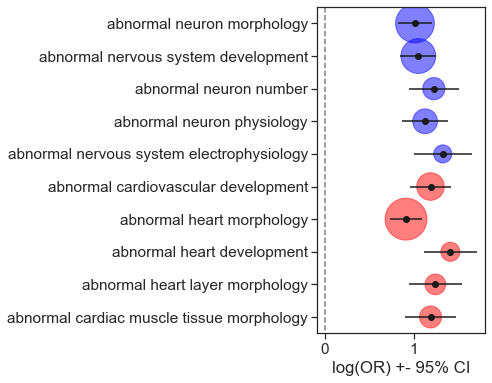

In [38]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})
plt.scatter(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),s=root_KO_df.loc[terms_plot]['num_genes_in_term'],alpha=.5,
           c=color_temp.tolist())

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.5,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-.5,len(terms_plot)-.5])

plt.gca().invert_yaxis()

# plt.savefig('../figures/ASD_CHD_brain_heart_MPO_root_enrichment_210716.png',dpi=300,bbox_inches='tight')



### 19. Compute enrichment of phenotype(s) in NetColoc subsystems.

In [39]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall

MP_full_results_df=pd.DataFrame(index=hier_df.index.tolist())

for MP_focal in MP_focal_top:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]
    print(MP_desc_focal)

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=MP_focal
        


    hyper_p_list = []
    num_genes_list = []
    genes_id_list = []

    OR_p_list,OR_CI_list,log_OR_list=[],[],[]
    for focal_cluster in hier_df.index.tolist():
        #print(focal_cluster)
        mFocal_genes = hier_df['CD_MemberList'].loc[focal_cluster].split(' ')


        from scipy.stats import hypergeom
        M=len(list(G_int.nodes())) # only keep genes in PCnet
        # Look up all entries matching focal_terms, and mFocal_genes
        mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
        mgi_temp = mgi_temp.dropna(subset=['human_ortholog'])
        mgi_genes = list(np.unique(mgi_temp['human_ortholog']))
        new_index=[g.upper() for g in mgi_temp.index.tolist()] 
        mgi_temp.index=new_index

        N=len(np.intersect1d(list(np.unique(mgi_temp.index.tolist())),list(G_int.nodes()))) # only keep genes in PCnet

        if len(np.intersect1d(mFocal_genes,mgi_temp.index.tolist()))>0:
            mgi_genes = mgi_temp.index.tolist()
            mgi_genes = list(np.intersect1d(mgi_genes,list(G_int.nodes())))
            x = len(np.intersect1d(mFocal_genes,mgi_genes))
            #print(x)
            n=len(mFocal_genes)

            #mgi_temp['MP_description']=mgi_temp['MP'].map(dict(MP2desc['description']))



            #print(hypergeom.sf(x,M,n,N))
            hyper_p_list.append(hypergeom.sf(x,M,n,N))
            num_genes_list.append(x)
            genes_id_list.append(' '.join(list(np.intersect1d(mFocal_genes,mgi_genes))))

            q00 = len(np.intersect1d(mgi_genes,mFocal_genes))
            q01 = len(mgi_genes)-q00

            q10 = len(mFocal_genes)-q00
            q11 = len(list(G_int.nodes()))-q00-q01-q10

            table_temp = [[q00,q01],[q10,q11]]

            CT= contingency_tables.Table2x2(table_temp)
            OR_p_temp = CT.log_oddsratio_pvalue()
            OR_CI_temp = CT.log_oddsratio_confint()
            log_OR_temp = CT.log_oddsratio
            #print(OR_p_temp)


            OR_p_list.append(OR_p_temp)
            OR_CI_list.append(OR_CI_temp)
            log_OR_list.append(log_OR_temp)


        else:
            hyper_p_list.append(1)
            num_genes_list.append(0)
            genes_id_list.append('')

            OR_p_list.append(1)
            OR_CI_list.append(0)
            log_OR_list.append(0)



    MP_focal_df = pd.DataFrame({MP_desc_focal+':-log(OR_p)':-np.log10(OR_p_list),
                                MP_desc_focal+':log_OR':log_OR_list,
                                MP_desc_focal+':num_genes':num_genes_list,
                                MP_desc_focal+':gene_ids':genes_id_list},index=hier_df.index.tolist())

    if MP_desc_focal+':-log(OR_p)' not in MP_full_results_df.columns.tolist():
        MP_full_results_df=MP_full_results_df.join(MP_focal_df)


abnormal neuron morphology
Genes and Terms to keep: 262
abnormal nervous system development
Genes and Terms to keep: 191
abnormal cardiovascular development
Genes and Terms to keep: 139
abnormal heart morphology
Genes and Terms to keep: 369
abnormal heart development
Genes and Terms to keep: 39
abnormal myocardial trabeculae morphology
Genes and Terms to keep: 7
abnormal neuron number
Genes and Terms to keep: 55
abnormal neuron physiology
Genes and Terms to keep: 47
abnormal heart layer morphology
Genes and Terms to keep: 49
abnormal cardiac muscle tissue morphology
Genes and Terms to keep: 62


C773
770


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
8,PKMTs methylate histone lysines,10622,26,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.120283e-16,[REAC:R-HSA-3247509],0.060046,query_1,433,0.366197,True,REAC,71
0,Chromatin organization,10622,91,Chromatin organization,REAC:R-HSA-4839726,3.123725e-57,[REAC:0000000],0.210162,query_1,433,0.333333,True,REAC,273
1,Chromatin modifying enzymes,10622,91,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.123725e-57,[REAC:R-HSA-4839726],0.210162,query_1,433,0.333333,True,REAC,273
16,Transcriptional Regulation by MECP2,10622,18,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,4.904561e-10,[REAC:R-HSA-212436],0.041570,query_1,433,0.305085,True,REAC,59
23,Ion homeostasis,10622,16,Ion homeostasis,REAC:R-HSA-5578775,8.247799e-09,[REAC:R-HSA-5576891],0.036952,query_1,433,0.296296,True,REAC,54


C774
273


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,PKMTs methylate histone lysines,10622,22,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.171292e-21,[REAC:R-HSA-3247509],0.135802,query_1,162,0.309859,True,REAC,71
0,Chromatin modifying enzymes,10622,72,Chromatin modifying enzymes,REAC:R-HSA-3247509,7.242424e-71,[REAC:R-HSA-4839726],0.444444,query_1,162,0.263736,True,REAC,273
1,Chromatin organization,10622,72,Chromatin organization,REAC:R-HSA-4839726,7.242424e-71,[REAC:0000000],0.444444,query_1,162,0.263736,True,REAC,273
17,Regulation of PTEN gene transcription,10622,12,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.500079e-09,[REAC:R-HSA-6807070],0.074074,query_1,162,0.203390,True,REAC,59
18,Formation of the beta-catenin:TCF transactivat...,10622,13,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,2.290174e-08,[REAC:R-HSA-201681],0.080247,query_1,162,0.142857,True,REAC,91


C775
241


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10622,19,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.396872e-08,[REAC:R-HSA-4839726],0.159664,query_1,119,0.069597,True,REAC,273
1,Chromatin organization,10622,19,Chromatin organization,REAC:R-HSA-4839726,4.396872e-08,[REAC:0000000],0.159664,query_1,119,0.069597,True,REAC,273


C777
165


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
7,Ion homeostasis,10622,16,Ion homeostasis,REAC:R-HSA-5578775,1.233108e-17,[REAC:R-HSA-5576891],0.133333,query_1,120,0.296296,True,REAC,54
11,NCAM signaling for neurite out-growth,10622,15,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.482072e-15,[REAC:R-HSA-422475],0.125000,query_1,120,0.254237,True,REAC,59
1,Cardiac conduction,10622,31,Cardiac conduction,REAC:R-HSA-5576891,1.457429e-31,[REAC:R-HSA-397014],0.258333,query_1,120,0.244094,True,REAC,127
4,L1CAM interactions,10622,27,L1CAM interactions,REAC:R-HSA-373760,1.170684e-26,[REAC:R-HSA-422475],0.225000,query_1,120,0.226891,True,REAC,119
20,Ion transport by P-type ATPases,10622,10,Ion transport by P-type ATPases,REAC:R-HSA-936837,5.597134e-09,[REAC:R-HSA-983712],0.083333,query_1,120,0.181818,True,REAC,55


C779
109


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,Transcriptional regulation by RUNX3,10622,10,Transcriptional regulation by RUNX3,REAC:R-HSA-8878159,4.595415e-09,[REAC:R-HSA-212436],0.169492,query_1,59,0.106383,True,REAC,94
17,FOXO-mediated transcription,10622,7,FOXO-mediated transcription,REAC:R-HSA-9614085,1.315692e-06,[REAC:R-HSA-212436],0.118644,query_1,59,0.106061,True,REAC,66
23,Constitutive Signaling by NOTCH1 HD+PEST Domai...,10622,6,Constitutive Signaling by NOTCH1 HD+PEST Domai...,REAC:R-HSA-2894862,8.174264e-06,[REAC:R-HSA-2894858],0.101695,query_1,59,0.105263,True,REAC,57
24,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,10622,6,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,REAC:R-HSA-2894858,8.174264e-06,[REAC:R-HSA-2644603],0.101695,query_1,59,0.105263,True,REAC,57
25,Signaling by NOTCH1 in Cancer,10622,6,Signaling by NOTCH1 in Cancer,REAC:R-HSA-2644603,8.174264e-06,[REAC:R-HSA-5663202],0.101695,query_1,59,0.105263,True,REAC,57


C787
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C802
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C804
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C815
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C816
6


""


C830
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C836
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C778
160


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,PKMTs methylate histone lysines,10622,20,PKMTs methylate histone lysines,REAC:R-HSA-3214841,8.971185e-23,[REAC:R-HSA-3247509],0.194175,query_1,103,0.281690,True,REAC,71
0,Chromatin modifying enzymes,10622,66,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.938361e-79,[REAC:R-HSA-4839726],0.640777,query_1,103,0.241758,True,REAC,273
1,Chromatin organization,10622,66,Chromatin organization,REAC:R-HSA-4839726,1.938361e-79,[REAC:0000000],0.640777,query_1,103,0.241758,True,REAC,273
11,Regulation of PTEN gene transcription,10622,11,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.500143e-10,[REAC:R-HSA-6807070],0.106796,query_1,103,0.186441,True,REAC,59
14,RMTs methylate histone arginines,10622,11,RMTs methylate histone arginines,REAC:R-HSA-3214858,3.302657e-09,[REAC:R-HSA-3247509],0.106796,query_1,103,0.139241,True,REAC,79


C824
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C797
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C806
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C776
173


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C842
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C812
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C849
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C800
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Axon guidance,10622,5,Axon guidance,REAC:R-HSA-422475,0.000003,[REAC:R-HSA-9675108],1.0,query_1,5,0.009107,True,REAC,549
2,Nervous system development,10622,5,Nervous system development,REAC:R-HSA-9675108,0.000003,[REAC:R-HSA-1266738],1.0,query_1,5,0.008711,True,REAC,574


C807
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C808
7


""


C780
45


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,Ion homeostasis,10622,10,Ion homeostasis,REAC:R-HSA-5578775,7.347196e-14,[REAC:R-HSA-5576891],0.256410,query_1,39,0.185185,True,REAC,54
17,NCAM signaling for neurite out-growth,10622,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.227840e-08,[REAC:R-HSA-422475],0.179487,query_1,39,0.118644,True,REAC,59
14,Post NMDA receptor activation events,10622,8,Post NMDA receptor activation events,REAC:R-HSA-438064,2.359736e-09,[REAC:R-HSA-442755],0.205128,query_1,39,0.105263,True,REAC,76
6,Cardiac conduction,10622,12,Cardiac conduction,REAC:R-HSA-5576891,3.123228e-13,[REAC:R-HSA-397014],0.307692,query_1,39,0.094488,True,REAC,127
15,Activation of NMDA receptors and postsynaptic ...,10622,8,Activation of NMDA receptors and postsynaptic ...,REAC:R-HSA-442755,8.009680e-09,[REAC:R-HSA-112314],0.205128,query_1,39,0.089888,True,REAC,89


C783
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10622,19,L1CAM interactions,REAC:R-HSA-373760,7.263732e-36,[REAC:R-HSA-422475],0.95,query_1,20,0.159664,True,REAC,119
11,NCAM signaling for neurite out-growth,10622,5,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,2.048648e-07,[REAC:R-HSA-422475],0.25,query_1,20,0.084746,True,REAC,59
6,Cardiac conduction,10622,10,Cardiac conduction,REAC:R-HSA-5576891,3.779888e-14,[REAC:R-HSA-397014],0.50,query_1,20,0.078740,True,REAC,127
8,COPI-mediated anterograde transport,10622,7,COPI-mediated anterograde transport,REAC:R-HSA-6807878,1.806428e-09,[REAC:R-HSA-199977],0.35,query_1,20,0.068627,True,REAC,102
7,Muscle contraction,10622,10,Muscle contraction,REAC:R-HSA-397014,2.583222e-12,[REAC:0000000],0.50,query_1,20,0.051282,True,REAC,195


C790
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Potassium Channels,10622,8,Potassium Channels,REAC:R-HSA-1296071,4.265582e-13,[REAC:R-HSA-112316],0.666667,query_1,12,0.077670,True,REAC,103
3,Ion homeostasis,10622,4,Ion homeostasis,REAC:R-HSA-5578775,1.852849e-06,[REAC:R-HSA-5576891],0.333333,query_1,12,0.074074,True,REAC,54
4,Ion transport by P-type ATPases,10622,4,Ion transport by P-type ATPases,REAC:R-HSA-936837,1.852849e-06,[REAC:R-HSA-983712],0.333333,query_1,12,0.072727,True,REAC,55
5,Potential therapeutics for SARS,10622,4,Potential therapeutics for SARS,REAC:R-HSA-9679191,6.704152e-06,[REAC:R-HSA-9679506],0.333333,query_1,12,0.050633,True,REAC,79
2,Neuronal System,10622,8,Neuronal System,REAC:R-HSA-112316,1.636934e-08,[REAC:0000000],0.666667,query_1,12,0.020000,True,REAC,400


C809
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Formation of the beta-catenin:TCF transactivat...,10622,4,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,0.000003,[REAC:R-HSA-201681],0.571429,query_1,7,0.043956,True,REAC,91


C781
28


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Chromatin modifying enzymes,10622,13,Chromatin modifying enzymes,REAC:R-HSA-3247509,5.122962e-17,[REAC:R-HSA-4839726],0.764706,query_1,17,0.047619,True,REAC,273
2,Chromatin organization,10622,13,Chromatin organization,REAC:R-HSA-4839726,5.122962e-17,[REAC:0000000],0.764706,query_1,17,0.047619,True,REAC,273


C782
26


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,HATs acetylate histones,10622,8,HATs acetylate histones,REAC:R-HSA-3214847,1.729678e-11,[REAC:R-HSA-3247509],0.615385,query_1,13,0.056738,True,REAC,141
0,Chromatin modifying enzymes,10622,10,Chromatin modifying enzymes,REAC:R-HSA-3247509,7.709298e-13,[REAC:R-HSA-4839726],0.769231,query_1,13,0.036630,True,REAC,273
1,Chromatin organization,10622,10,Chromatin organization,REAC:R-HSA-4839726,7.709298e-13,[REAC:0000000],0.769231,query_1,13,0.036630,True,REAC,273
4,Regulation of TP53 Activity,10622,5,Regulation of TP53 Activity,REAC:R-HSA-5633007,9.185246e-06,[REAC:R-HSA-3700989],0.384615,query_1,13,0.031250,True,REAC,160


C784
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,14,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.558357e-27,[REAC:R-HSA-3247509],0.823529,query_1,17,0.197183,True,REAC,71
1,Chromatin modifying enzymes,10622,14,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.503510e-19,[REAC:R-HSA-4839726],0.823529,query_1,17,0.051282,True,REAC,273
2,Chromatin organization,10622,14,Chromatin organization,REAC:R-HSA-4839726,3.503510e-19,[REAC:0000000],0.823529,query_1,17,0.051282,True,REAC,273


C811
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C786
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,NCAM signaling for neurite out-growth,10622,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.860626e-11,[REAC:R-HSA-422475],0.466667,query_1,15,0.118644,True,REAC,59
4,Regulation of insulin secretion,10622,5,Regulation of insulin secretion,REAC:R-HSA-422356,5.636173e-07,[REAC:R-HSA-163685],0.333333,query_1,15,0.064103,True,REAC,78
6,Integration of energy metabolism,10622,5,Integration of energy metabolism,REAC:R-HSA-163685,1.981410e-06,[REAC:R-HSA-1430728],0.333333,query_1,15,0.046729,True,REAC,107
5,Axon guidance,10622,8,Axon guidance,REAC:R-HSA-422475,1.981410e-06,[REAC:R-HSA-9675108],0.533333,query_1,15,0.014572,True,REAC,549
7,Nervous system development,10622,8,Nervous system development,REAC:R-HSA-9675108,2.107978e-06,[REAC:R-HSA-1266738],0.533333,query_1,15,0.013937,True,REAC,574


C789
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Chromatin modifying enzymes,10622,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.808162e-08,[REAC:R-HSA-4839726],0.857143,query_1,7,0.021978,True,REAC,273
2,Chromatin organization,10622,6,Chromatin organization,REAC:R-HSA-4839726,1.808162e-08,[REAC:0000000],0.857143,query_1,7,0.021978,True,REAC,273


C795
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C791
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10622,5,HATs acetylate histones,REAC:R-HSA-3214847,5.470672e-08,[REAC:R-HSA-3247509],0.833333,query_1,6,0.035461,True,REAC,141
1,Chromatin modifying enzymes,10622,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,5.083965e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
2,Chromatin organization,10622,5,Chromatin organization,REAC:R-HSA-4839726,5.083965e-07,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C785
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10622,15,L1CAM interactions,REAC:R-HSA-373760,5.608502e-28,[REAC:R-HSA-422475],0.9375,query_1,16,0.126050,True,REAC,119
6,Cardiac conduction,10622,9,Cardiac conduction,REAC:R-HSA-5576891,1.827283e-13,[REAC:R-HSA-397014],0.5625,query_1,16,0.070866,True,REAC,127
7,Muscle contraction,10622,9,Muscle contraction,REAC:R-HSA-397014,8.067196e-12,[REAC:0000000],0.5625,query_1,16,0.046154,True,REAC,195
3,Axon guidance,10622,15,Axon guidance,REAC:R-HSA-422475,5.095604e-18,[REAC:R-HSA-9675108],0.9375,query_1,16,0.027322,True,REAC,549
4,Nervous system development,10622,15,Nervous system development,REAC:R-HSA-9675108,7.999296e-18,[REAC:R-HSA-1266738],0.9375,query_1,16,0.026132,True,REAC,574


C792
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,9.664742e-10,[REAC:R-HSA-3247509],0.833333,query_1,6,0.070423,True,REAC,71
1,Chromatin modifying enzymes,10622,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.965646e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
2,Chromatin organization,10622,5,Chromatin organization,REAC:R-HSA-4839726,2.965646e-07,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C803
7


""


C805
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10622,4,HATs acetylate histones,REAC:R-HSA-3214847,2.976194e-07,[REAC:R-HSA-3247509],1.0,query_1,4,0.028369,True,REAC,141
1,Chromatin modifying enzymes,10622,4,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.423520e-06,[REAC:R-HSA-4839726],1.0,query_1,4,0.014652,True,REAC,273
2,Chromatin organization,10622,4,Chromatin organization,REAC:R-HSA-4839726,1.423520e-06,[REAC:0000000],1.0,query_1,4,0.014652,True,REAC,273


C813
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C841
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C853
4


""


### 20. Annotate NetColoc systems map with mouse knockout data, seed genes, and enriched GO terms

In [42]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
MP_full_results_df['gprofiler_name'].loc[root_node]=d1+'-'+d2+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal cardiovascular development:-log(OR_p),abnormal cardiovascular development:log_OR,...,abnormal cardiac muscle tissue morphology:-log(OR_p),abnormal cardiac muscle tissue morphology:log_OR,abnormal cardiac muscle tissue morphology:num_genes,abnormal cardiac muscle tissue morphology:gene_ids,gprofiler_name,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
C773,24.857154,1.015059,142,AFDN AFF1 ANK2 ANK3 ARID1B ATM ATP1A3 ATP1B2 A...,23.315916,1.053248,120,AFDN AGO2 ANKRD17 APC ARHGEF7 ARID1A ARID1B BC...,22.322180,1.190571,...,15.458468,1.191350,57,AKAP13 AKAP6 ANKRD17 ARID1A ARID2 BRAF BRD2 CA...,ASD-CHD systems map,47,29,0.061039,0.037662,0.901299
C774,4.175785,0.691050,40,ARID1B BCL11A BRD7 BRPF1 CHD7 CLOCK CTNNB1 DNM...,18.957400,1.379683,57,ARID1A ARID1B BCL11A BRD1 BRD2 BRPF1 CHD7 CREB...,21.780243,1.621614,...,8.043151,1.281307,23,ARID1A BRD2 CHD7 CREBBP EP300 EPAS1 EZH2 FOXO1...,PKMTs methylate histone lysines,20,11,0.073260,0.040293,0.886447
C775,2.548761,0.572584,32,AFF1 ATM ATRX ATXN1 ATXN2 BRAF CDC14A CLEC16A ...,3.735694,0.738429,30,AGO2 ANKRD17 APC ARHGEF7 BRAF C2CD3 CDK13 CHD8...,3.508393,0.834795,...,2.170585,0.782679,13,AKAP13 ANKRD17 ARID2 BRAF CDK13 DICER1 FNIP1 N...,Chromatin modifying enzymes,11,9,0.045643,0.037344,0.917012
C777,23.642993,1.720951,53,ANK2 ANK3 ATP1A3 ATP1B2 CACNA1A CACNA1D CACNA1...,2.464473,0.703450,20,CACNA1A CNTN1 CNTN2 DSCAM FGFR2 ISL1 LGI1 MAPT...,2.343840,0.800111,...,6.070921,1.353035,15,AKAP6 CACNA1C CACNA1H CASQ2 FGFR2 FKBP1B ISL1 ...,Ion homeostasis,12,6,0.072727,0.036364,0.890909
C779,6.463930,1.186408,24,AFDN ATXN1 BCL11A CTNNB1 FOXG1 FOXN4 GLI2 HIPK...,16.977295,1.820387,32,AFDN BCL11A CREBBP CTBP1 CTBP2 CTNNB1 EP300 FO...,21.162881,2.138935,...,7.498114,1.654940,13,CREBBP EP300 EPAS1 FOXO1 GATA4 HDAC9 MEF2C MYC...,Transcriptional regulation by RUNX3,7,6,0.064220,0.055046,0.880734


### 21. Export NetColoc systems map to NDEx, with default style. 

Default style maps fraction of seed genes from seed set 1 (red) and seed set 2 (blue) to node pie charts. Fraction of genes in each system which are in neither seed set, but which are implicated by the network are indicated with white. 

In [44]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name('ASD_CHD_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)
        
# some CDAPs properties were corrupted on networkx conversion. Fix them here
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='36041bac-d2e3-11eb-b666-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [47]:
#Upload to NDEx
G_hier_cx.set_name('ASD_CHD_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


### 22. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [45]:
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [49]:
# apply a template style 
G_hier_cx.set_name('ASD_CHD_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


### 23. Add genes associated with mouse knockout phenotypes to NetColoc subgraph, export to NDEx. 

In [47]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node][MP].split(' ')
    node_df[MP]=0
    node_df[MP].loc[focal_genes]=1
node_df.head()

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds,abnormal neuron morphology:gene_ids,abnormal nervous system development:gene_ids,abnormal cardiovascular development:gene_ids,abnormal heart morphology:gene_ids,abnormal heart development:gene_ids,abnormal myocardial trabeculae morphology:gene_ids,abnormal neuron number:gene_ids,abnormal neuron physiology:gene_ids,abnormal heart layer morphology:gene_ids,abnormal cardiac muscle tissue morphology:gene_ids
PTEN,1,1,17.775818,18.270646,324.775666,ASD,CHD,2,1,1,1,1,1,0,1,1,1,1
CTNNB1,1,1,15.369891,16.212593,249.185790,ASD,CHD,2,1,1,1,1,0,0,0,1,1,0
POGZ,1,1,12.518539,13.035299,163.182897,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
KMT2C,1,1,12.964197,12.579514,163.083297,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
NSD1,1,1,12.263667,12.748115,156.338630,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0


In [53]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name('ASD_CHD_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)

773
26351
Generating CX


### Upload cosine-similarity transformed NetColoc subgraph to NDEx

In [59]:
#Annotate network
print(len(G_cosSim.nodes()))
print(len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name('ASD_CHD_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

773
7862
Generating CX


### Add 4 networks from above to network set

### ----------- is there a way to check if network set exists...? -----------

In [271]:
# need a way to check if network set exists...

# networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset('ASD-CHD network set','network set for ASD-CHD NetColoc subgraph and systems map')
# networkSetURL

'http://public.ndexbio.org/v2/networkset/8d3cb8f5-e5cf-11eb-b666-0ac135e8bacf'

In [272]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'http://public.ndexbio.org/v2/networkset/8d3cb8f5-e5cf-11eb-b666-0ac135e8bacf/members'

# TODO: ADD PARAMETER LIST TO NDEX METADATA SOMEWHERE

Parameters:
- background interactome UUID
- clustering algorithm + params
- d1 name, d2 name